PSEUDO CODE:

Algorithm: REINFORCE
### step 1 
Initialise parameters: step size 𝛼 ∈ (0,1]

### step 2 
Initialise policy network 𝜋 with parameters 𝜽

## Main loop 
### step 3 
For episode = 1, 𝑀 do

    Generate an episode trajectory 𝜏~𝜋𝜽

### step 4 

    For 𝑡 = 1, 𝑇 − 1 do

       G <- Sum of rewards

       𝜽 <- update parameters

    End For
    
End For (related to episode loop)


In [138]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

#from gym.wrappers.record_video import RecordVideo


# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        action_probs = torch.softmax(self.fc2(x), dim=-1)
        return action_probs

# Reinforce algorithm
def reinforce(env, num_episodes, max_steps_per_episode, gamma=0.99, lr=0.001):
    policy_net = PolicyNetwork(state_size=env.observation_space.shape[0],
                               action_size=env.action_space.n)
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)

    episode_rewards_history = []
    #last_episode_video_path = './Documents/Reinforcement_Learning/RL_proj/rl-group-assignment'
    
    for episode in range(num_episodes):
        state = env.reset()[0]
        episode_rewards = []
        log_probs = []

        #if episode == num_episodes-1:
            #self.env.start_video_recorder()
        #    pass
        
        
        for step in range(max_steps_per_episode):


            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_probs = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            
            #print(env.step(action.item()))
            next_state, reward, done,_, _ = env.step(action.item())
            episode_rewards.append(reward)
            log_probs.append(log_prob)
            
            if done:
                break
                
            state = next_state

        #if episode == num_episodes-1:
        #    pass
            #self.env.close_video_recorder()

        # Compute the discounted cumulative reward
        discounted_rewards = []
        R = 0
        for r in episode_rewards[::-1]:
            R = r + gamma * R
            discounted_rewards.insert(0, R)

        episode_rewards_history.append(sum(episode_rewards))
        
        # Normalize the discounted rewards
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        # Compute the policy gradient and update the policy network
        policy_losses = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            policy_losses.append(-log_prob * reward)
        
        policy_loss = torch.stack(policy_losses).sum()
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
    #env.close()   
    return policy_net, episode_rewards_history

# Train the policy network
env = gym.make('LunarLander-v2',render_mode = "rgb_array")
#env = RecordVideo(env = env, video_folder="./videos",name_prefix='Last_episode_video')
policy_net, episode_rewards_history = reinforce(env, num_episodes=1500, max_steps_per_episode=1000)

os.system('say "Finished"')


/Users/luisweekes/anaconda3/envs/myenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0

In [147]:
import random 

def random_lunar(env, num_episodes, max_steps_per_episode):

    episode_rewards_history = []
    #last_episode_video_path = './Documents/Reinforcement_Learning/RL_proj/rl-group-assignment'
    
    for episode in range(num_episodes):
        state = env.reset()[0]
        episode_rewards = []

        for step in range(max_steps_per_episode):
            num_actions = env.action_space.n
            action = random.randint(0, num_actions-1)
            next_state, reward, done,_, _ = env.step(action)
            episode_rewards.append(reward)

            if done:
                break
                
            state = next_state

        episode_rewards_history.append(sum(episode_rewards))
    return policy_net, episode_rewards_history

env = gym.make('LunarLander-v2',render_mode = "rgb_array")
random_l, episode_rewards_history_rand = random_lunar(env, num_episodes=1500, max_steps_per_episode=1000)

/Users/luisweekes/anaconda3/envs/myenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Text(0.5, 1.0, 'Rewards by Episode For Reinforce in Lunar Lander')

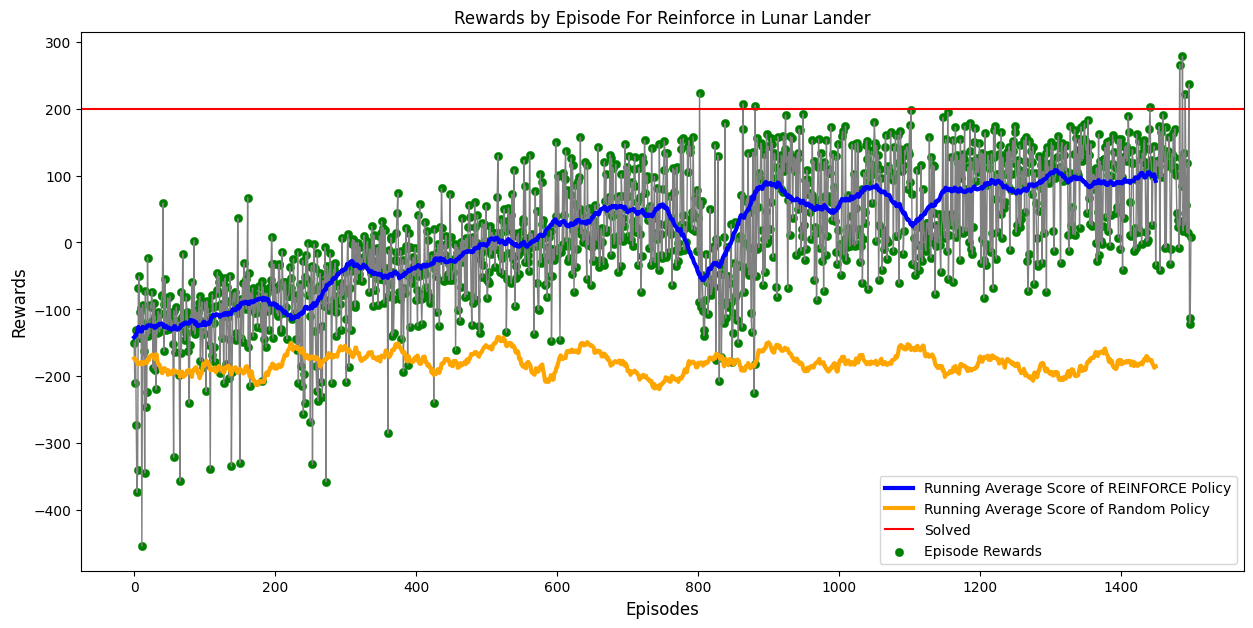

In [152]:
import matplotlib.pyplot as plt
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y
episode_rewards_history_reinforce = np.array(episode_rewards_history)
avg_score_reinforce = running_mean(episode_rewards_history)
episode_rewards_history_rand = np.array(episode_rewards_history_rand)
avg_score_rand = running_mean(episode_rewards_history_rand)

plt.figure(figsize=(15,7))
plt.ylabel("Rewards",fontsize=12)
plt.xlabel("Episodes",fontsize=12)
plt.plot(episode_rewards_history_reinforce, color='gray' , linewidth=1)
plt.plot(avg_score_reinforce, color='blue', linewidth=3,label = 'Running Average Score of REINFORCE Policy')
plt.plot(avg_score_rand, color='orange', linewidth=3,label = 'Running Average Score of Random Policy')
plt.axhline(y=200, color='r', linestyle='-',label = 'Solved')
plt.scatter(np.arange(episode_rewards_history_reinforce.shape[0]),episode_rewards_history_reinforce, 
            color='green' , linewidth=0.3, label='Episode Rewards')
plt.legend()

plt.title('Rewards by Episode For Reinforce in Lunar Lander')


https://www.linkedin.com/pulse/human-vs-ai-simple-experiment-ibad-rehman/